# Описание задачи

## Информация из предыдущих этапов

**Постановка кейса.**

В рамках практических заданий мы будем работать аналитиком на платформе по подаче объявлений. По результатам исследований мы выяснили, что недавно введенной функцией доставки пользуются редко. В рамках идей по исправлению ситуации была предложена инициатива выдать скидку в 20% на данную услугу, зачеркнув старую цену и написав рядом новую на карточках объявлений, в которых доступна доставка. Нам поставлена задача оценить данную инициативу.

**Метрики.**

По результатам командного обсуждения было принято назначить целевой метрикой выручку. Прочие метрики, за которыми ваша команда планирует наблюдать: выручка с доставки, пользователи с доставкой, количество ошибок на экранах доставочный айтемов, количество заказов без доставки.

**Критерий.**

По результатам предыдущего исследования наш выбор пал на тест Стьюдента. Предполагаем, что будем использовать его.

**MDE, N, alpha, beta**

По результатам обсуждения с аналитиками и продуктами было принято решение остановиться на ошибках 1 и 2 рода в 1% при MDE в 1.4% для основной метрики. N = 5 mln в каждой группе, длительность эксперимента - 21 день.

## Текущее задание

Наконец, пришла пора переходить к запуску теста! Но для этого нам нужна хорошо работающая система сплитования тест-контроль. Вам предстоит реализовать ее, провалидировать, модифицировать и применить. Тестировать все это дело будем при помощи все того же датасета task_1. Приступим!

# Реализация сплиттера

Напишите функцию, которая принимает на вход массив из id (pandas.Series или numpy.ndarray), соль эксперимента и количество бинов (бакетов), на которое нужно разбить массив. Возвращать функция должна новый массив, равный исходному по размеру, с номером бакета, который соответствует этому айди. Проверьте ваш код на примере ниже. Получилось ли распределение юзеров по бакетам равномерным? Для ответа на этот вопрос постройте график распределения, а также проведите статистический тест: Хи-квадрат или Колмагорова-Смирнова - выберите один и аргументируйте свой выбор.

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import hashlib

In [20]:
def get_bucket(ids, salt, n_bin):
    """
    Распределяет пользователей по бакетам на основе их ID, соли и количества бакетов.
    Параметры:
    ids: Массив ID пользователей (pandas.Series или numpy.ndarray).
    salt: Соль эксперимента (строка).
    n_bin: Количество бакетов (целое число).
    
    Возвращает: Массив с номерами бакетов для каждого пользователя.
    """
    # Применяем хэширование к ID пользователей с солью
    def hash_user_id(user_id):
        hashed = hashlib.sha256((str(user_id) + salt).encode()).hexdigest()
        return int(hashed, 16) % n_bin
    
    # Применяем функцию хэширования к каждому ID
    buckets = np.array([hash_user_id(user_id) for user_id in ids])
    return buckets

In [3]:
data = pd.read_csv('task_2.csv')

Пример

In [21]:
salt = 'delivery_sale_20'
n_bin = 100
buckets = get_bucket(ids=data['user_id'], salt=salt, n_bin=n_bin)

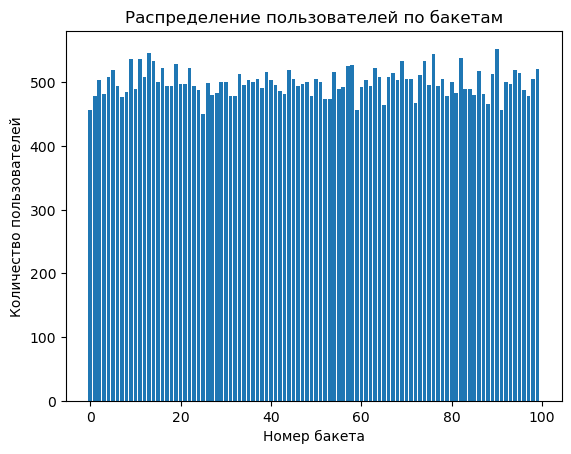

In [22]:
import matplotlib.pyplot as plt

bucket_counts = pd.Series(buckets).value_counts().sort_index()
plt.bar(bucket_counts.index, bucket_counts.values)
plt.xlabel("Номер бакета")
plt.ylabel("Количество пользователей")
plt.title("Распределение пользователей по бакетам")
plt.show()

In [23]:
from scipy.stats import chisquare

expected_count = len(data['user_id']) / n_bin

# Проверяем Хи-квадратом, так как он первоначально использовался для сравнения ожидаемых частот с теоретическими
chi2_stat, p_value = chisquare(bucket_counts, f_exp=expected_count)
print(f"Хи-квадрат статистика: {chi2_stat}")
print(f"p-value: {p_value}")

Хи-квадрат статистика: 84.128
p-value: 0.8570126084826104


На выходе получилось равномерное распределение бакетов, Хи-квадрат подтвердил, что частоты в бакетах соответствуют теоретическим

# Валидация сплиттера

Однако делать вывод о корректности работы на одном примере нельзя. Валидация - наше все. Давайте проведем 10 тысяч симуляций, в каждой из которых будем брать новую соль, разбивать на бины, первую половину бинов отправлять тест, вторую - в контроль. Каждый раз будем с помощью теста хи-квадрат ИЛИ Колмагорова-Смирнова (то, что вы выбрали в предыдущем пункте) проверять равномерность распредления по бинам, а с помощью теста Стьюдента равенство средних в тесте и контроле по целевой метрике теста ['revenue']. В итоге должно получиться 2 массива по 10 тысяч p value. Проанализируйте их и сделайте выводы

In [25]:
from tqdm import tqdm
from scipy.stats import chisquare, ttest_ind

bins_variation = [20, 50, 100, 200] # возможные варианты бинов
chisquare_pvalue = [] # заготовка, куда будем складывать pvalue chisquare тестов
ttest_pvalue = [] # заготовка, куда будем складывать pvalue t тестов
n_iter = 10_000
for i in tqdm(range(n_iter)):
    current_salt = 'experiment_' + str(i)
    n_bin = np.random.choice(a=bins_variation, size=1)[0]
    data['bucket'] = get_bucket(ids=data['user_id'], salt=current_salt, n_bin=n_bin)
    data['is_test'] = data['bucket'] < n_bin / 2 # определяем группу по бину
    
    # Проверим равномерностm распределения по бакетам
    bucket_counts = data['bucket'].value_counts().sort_index()
    expected_count = len(data) / n_bin
    chi2_stat, p_value_chi = chisquare(bucket_counts, f_exp=expected_count)
    chisquare_pvalue.append(p_value_chi)
    
    # Проверим равенства средних
    test_revenue = data[data['is_test']]['revenue']
    control_revenue = data[~data['is_test']]['revenue']
    t_stat, p_value_ttest = ttest_ind(test_revenue, control_revenue)
    ttest_pvalue.append(p_value_ttest)


100%|██████████| 10000/10000 [16:50<00:00,  9.89it/s]


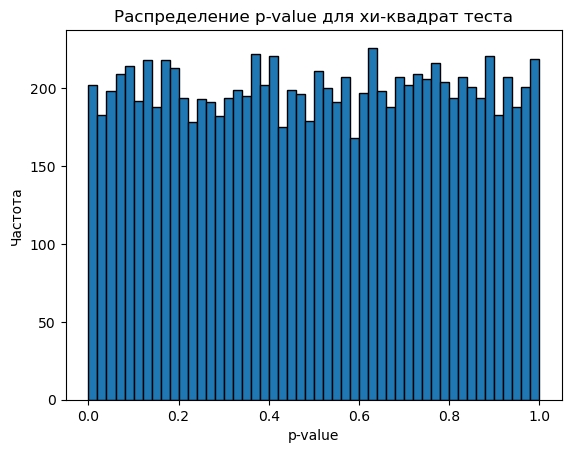

In [26]:
plt.hist(chisquare_pvalue, bins=50, edgecolor='black')
plt.title("Распределение p-value для хи-квадрат теста")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

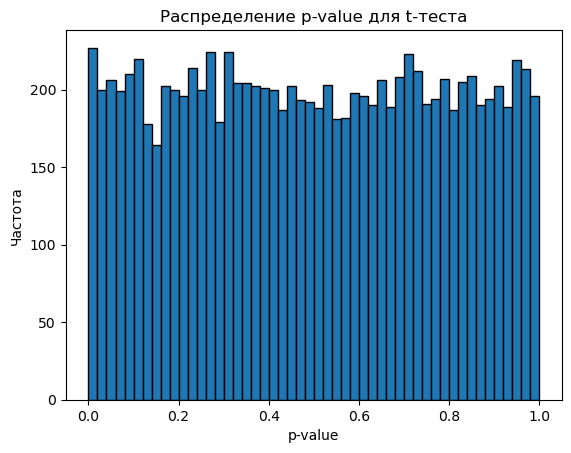

In [27]:
plt.hist(ttest_pvalue, bins=50, edgecolor='black')
plt.title("Распределение p-value для t-теста")
plt.xlabel("p-value")
plt.ylabel("Частота")
plt.show()

In [28]:
print(f"Доля p-value < 0.05 для хи-квадрат теста: {np.mean(np.array(chisquare_pvalue) < 0.05):.3f}")
print(f"Доля p-value < 0.05 для t-теста: {np.mean(np.array(ttest_pvalue) < 0.05):.3f}")

Доля p-value < 0.05 для хи-квадрат теста: 0.049
Доля p-value < 0.05 для t-теста: 0.053


В целом сплитование работает хорошо

По результатам предыдущих заданий вам удалось получить отличную функцию для разбиения, однако продуктовый менеджер, углубившись в анализ, просит ее доработать. Он согласен, что с точки зрения статистики, - все окей, но получается, что в 5% случаев в эксперименте контрольная и тестовая группа будут заранее статистически значимо отличаться. С точки зрения же бизнеса это означает, что каждый 20-ый эксперимент имеет предпосылки к недостоверности.

Вам поручено модифицировать вашу функцию так, чтобы она проверяла наличие статистической значимой разницы между средними метрик после разбиения на тест и контроль. Подробнее о принимаемых алгоритме функции, входных и выходных параметрах можно узнать из сигнатуры функции и docstring'и. Помните, что чем эффективнее вы напишите ваш код, тем быстрее вы сможете провести дальнейшие исследования с помощью методов Монте-Карло!

После реализации функции проведите 10_000 Монте-Карло симуляций с различными бинами и солями, ответив на следующие вопросы:
- Как выглядит распределение номера успешной попытки (i) в случае, если передаем только 1 метрику - revenue? А как в случае всех 5 метрик?
- Какому семейству принадлежат эти распределения? С какими параметрами?
- Согласуетя ли наблюдаемая картина с ожидаемой, есть ли у нас основания подозревать некорректную работу функции?






In [29]:
from tqdm import tqdm
from collections import namedtuple
split_result = namedtuple('split_result', ['bucket', 'is_test', 'i'])

In [40]:
def get_balanced_bucket(
    data: pd.DataFrame,
    id_column_name: str,
    metrics_column_names: str | list,
    initial_salt: str = '',
    n_bin: int = 100,
    test_bins: int = 50,
    alpha: float = 0.05,
  ):
    """
    Функция работает по следующем алгоритму:
    1. разбивает data на n_bin с помощью функции get_bucket с солью initial_salt + '1';
    2. данные с бакетом до test_bins отправляются в тест, начиная с test_bins - в контроль;
    3. проверяется наличие стат. значимой разницы в метрике или метриках из metrics_column_names;
    4. если стат. значимая разница на уровне alpha наблюдается хотя бы у 1 метрики,
    то возвращаемся к пунтку 1 с солью initial_salt + '2';
    5. как только получили разбиение без стат. значимой разницы завершаем работу, возвращая:
    массив с номером бакетов,
    массив is_test (1 для тестовой и 0 для контрольной),
    i - итерация, с которой удалось выполнить разбиение без стат. значимой разницы в метриках.
    С помощью i в дальнейшем можно будем восстановить соль разбиения. Например, если начальная
    соль была 'our_exp' и разбиение выполнилось со второго раза, то i = 2, а соль = 'our_exp2'

    Входные данные:
    data: pandas.DataFrame - таблица с данными.
    id_column_name: строка - название колонки с id, по которым будем брать хэш.
    metrics_column_names: строка или список строк - по какой (каким) метрикам
      будем проверять отсутствие стат. значимости.
    initial_salt: строка - начальная соль. К ней будет прибавляться str(i),
      где i - номер итерации (попытки сбалансированного разбиения)
    n_bin: целое число - общее количество бинов, на которое будем делить данные.
    test_bins: целое число - количество бинов тестовой группы.
    alpha: float - уровень значимости для проверки сбалансированности разбиения.

    Выходные данные - именновый кортеж split_result со следующими атрибутами:
    bucket: pandas.Series с бакетами (бинами),
    is_test: pandas.Series с определением тестовой группы (1 или 0),
    i: номер попытки, с которой удалось провести сбалансированное разбиение (int).
    """
    i = 1  # Номер итерации
    while True:
        # Преобразуем metrics_column_names в список, если это строка
        if isinstance(metrics_column_names, str):
            metrics_column_names = [metrics_column_names]
        
        # Разбиваем данные на бакеты
        data['bucket'] = get_bucket(ids=data[id_column_name], salt=initial_salt + str(i), n_bin=n_bin)
        data['is_test'] = data['bucket'] < test_bins  # True для теста, False для контроля

        # Проверяем равенство средних для всех метрик
        is_balanced = True
        for metric in metrics_column_names:
            test_metric = data[data['is_test']][metric]
            control_metric = data[~data['is_test']][metric]
            _, p_value = ttest_ind(test_metric, control_metric)
            if p_value < alpha:
                is_balanced = False
                break  # Прерываем проверку, если найдена значимая разница

        # Если разбиение сбалансировано, завершаем цикл
        if is_balanced:
            return split_result(data['bucket'], data['is_test'], i)

        # Иначе увеличиваем счетчик итераций и пробуем снова
        i += 1

In [45]:
# это готовый и корректный код для исследования
salts_1 = []
salts_5 = []
bins_variation = [20, 50, 100, 200]
alpha = 0.05
all_metrics = [
    'revenue',
    'delivery_revenue',
    'has_delivery',
    'error_count',
    'order_wo_delivery'
    ]
for i in tqdm(range(10_000)):
    n_bin = np.random.choice(a=bins_variation, size=1)[0]
    test_bins = n_bin // 2
    salt = str(i) + 'our_experiment'
    _, _, i_1 = get_balanced_bucket(
      data=data,
      id_column_name='user_id',
      metrics_column_names='revenue',
      initial_salt=salt,
      n_bin=n_bin,
      test_bins=test_bins,
      alpha=alpha,
    )
    _, _, i_5 = get_balanced_bucket(
      data=data,
      id_column_name='user_id',
      metrics_column_names=all_metrics,
      initial_salt=salt,
      n_bin=n_bin,
      test_bins=test_bins,
      alpha=alpha,
    )
    salts_1.append(i_1)
    salts_5.append(i_5)

100%|██████████| 10000/10000 [38:41<00:00,  4.31it/s]


In [46]:
salts_1, salts_5 = pd.Series(salts_1), pd.Series(salts_5)

<Axes: ylabel='Count'>

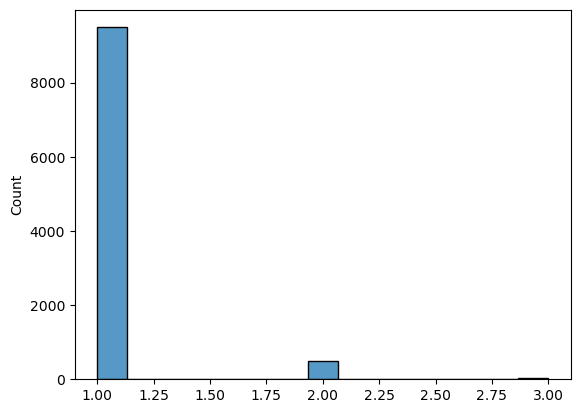

In [47]:
sns.histplot(salts_1)

<Axes: ylabel='Count'>

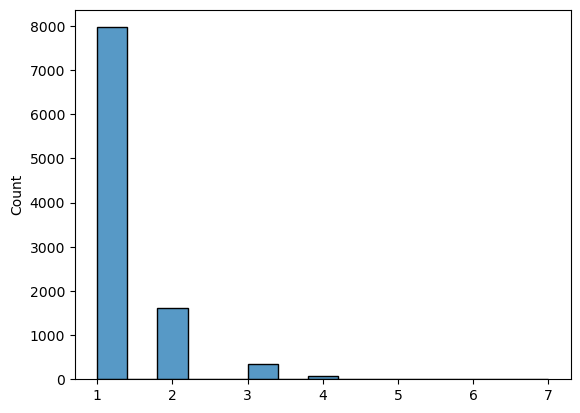

In [48]:
sns.histplot(salts_5)

Распределение количества попыток выглядит похожим на экспоненциальное распределение. С увеличением числа метрик увеличивается количество итераций, где потребовалось 2 и 3 попытки, и появляются итерации с бОльшим числом попыток вплоть до 7.